<hr style="height:2px;">

# Deep learning based Ion beam tomography (Deep IBT)

This notebook demonstrates training data generation for a 3D → 2D denoising+projection task, where corresponding pairs of low and high quality 3D stacks can be acquired. The surface of interest is then extracted from the high quality stacks with a conventional projection method, such as [PreMosa](https://doi.org/10.1093/bioinformatics/btx195).

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches_reduced_target

<hr style="height:2px;">

# STEP1: DATA GENERATION, Load organized ion beam data (raw stack and stirm single slice)

First we download some example data, consisting of low-SNR 3D stacks with corresponding 2D surface images extracted from the high-SNR stacks.  
Note that `GT` stands for [ground truth](https://en.wikipedia.org/wiki/Ground_truth) and represents high signal-to-noise ratio (SNR) images.

We can plot one of the training pairs:

In [3]:
#y = imread('data/retinasr/s5-c05long-31slices-si.tif')
#x = imread('data/retina/s5-c05long-31slices-si.tif')

y = imread('data/retinasr/imbrducellstirm.tif')
x = imread('data/retina/imbrducell.tif')

print('input  image size =', x.shape)
print('output image size =', y.shape)




input  image size = (21, 768, 768)
output image size = (768, 768)


<hr style="height:2px;">

# Generate training data for denoising + projection CARE

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR images and the semantics of each axis (e.g. which one is considered a color channel, etc.).

Here we have several folders with low-SNR images and one folder "GT" with the high-SNR extracted surface images. Note that corresponding images are TIFF files with identical names.  
For this case, we use `RawData.from_folder` and set `axes = 'ZYX'` to indicate the semantic axes of the low-SNR input stacks.

In [5]:
raw_data = RawData.from_folder (
    basepath    = 'data',
    source_dirs = ['retina'],
    target_dir  = 'retinasr',
    axes        = 'ZYX',
)

FileNotFoundError: data\retinasr\imbrducell.tif

From corresponding images, we now generate some 3D/2D patches. As a general rule, use a `patch_size` that is a power of two along all non-channel axes, here at least divisible by 16. You can use `None` along the projection axis (typically `Z`, i.e. use `reduction_axes = 'Z'`) to indicate that each patch should contain the entire image along this axis.
Furthermore, set `target_axes` appropriately if the target images are missing the projection axis.

Note that returned values `(X, Y, XY_axes)` by `create_patches_reduced_target` are not to be confused with the image axes X and Y.  
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.

In [11]:
X, Y, XY_axes = create_patches_reduced_target (
    raw_data            = raw_data,
    patch_size          = (None,32,32),
    n_patches_per_image = 200,
    target_axes         = 'YX',
    reduction_axes      = 'Z',
    save_file           = 'data/my_training_data.npz',
)

    1 raw images x    1 transformations   =     1 images
    1 images     x  200 patches per image =   200 patches in total
Input data:
data: target='retinasr', sources=['retina'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Broadcast target image to the shape of source
Patch size:
26 x 32 x 32


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


Saving data to data\my_training_data.npz.


In [12]:
print("shape of X   =", X.shape)
print("shape of Y   =", Y.shape)
print("axes  of X,Y =", XY_axes)

shape of X   = (200, 1, 26, 32, 32)
shape of Y   = (200, 1, 1, 32, 32)
axes  of X,Y = SCZYX


## Show

This shows some of the generated patch pairs (even rows: maximum projection of *source*, odd rows: *target*)

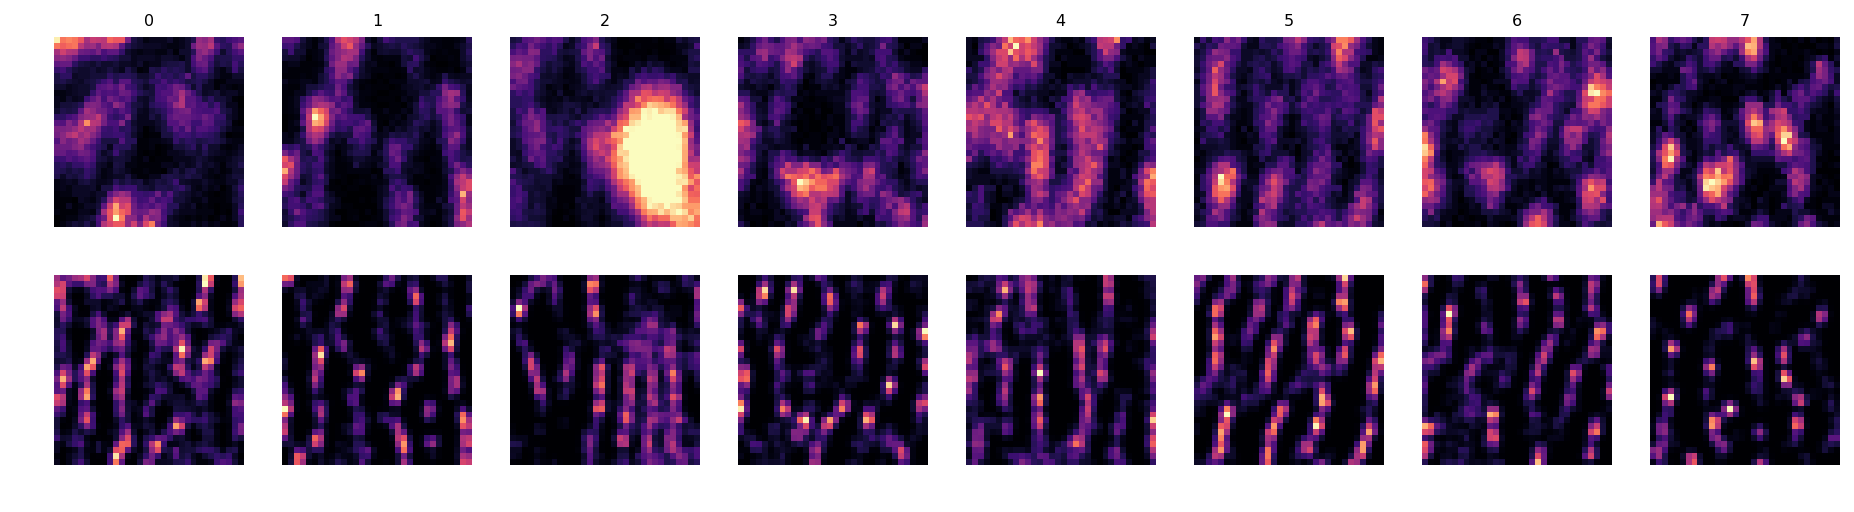

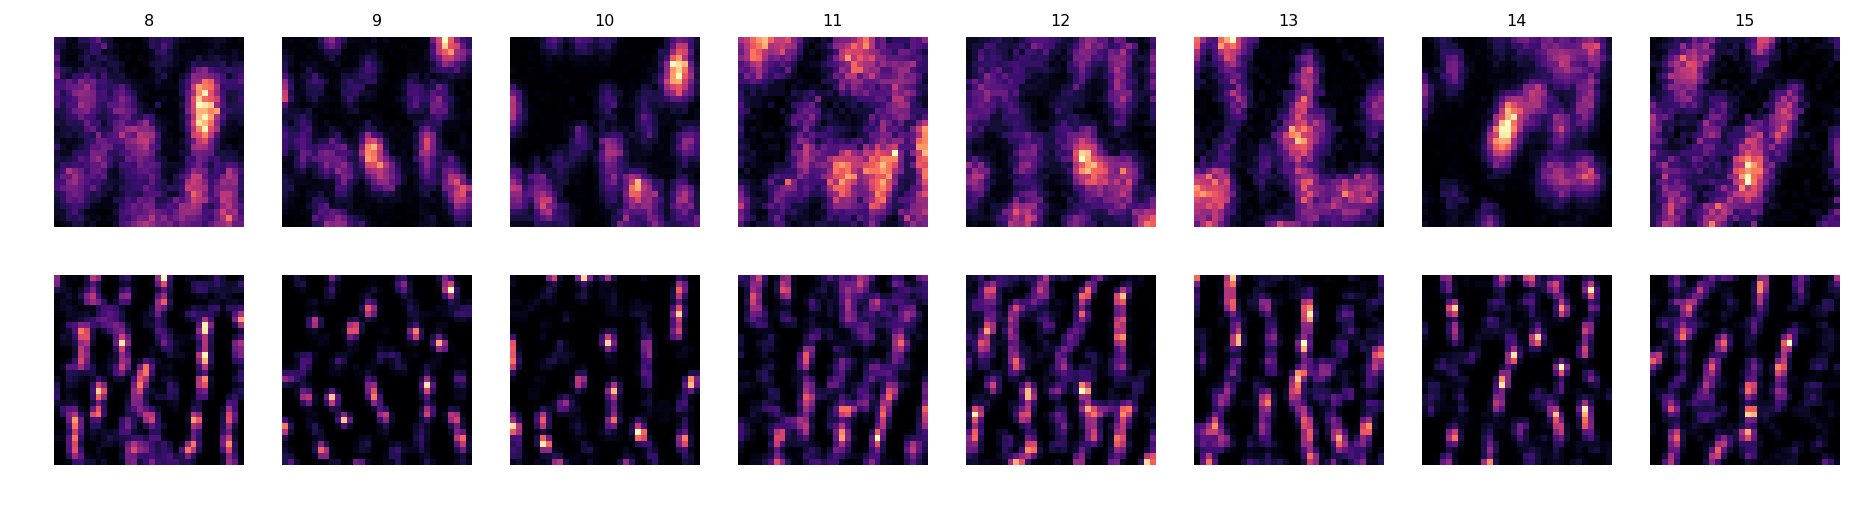

In [13]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;

<hr style="height:2px;">

# STEP 2: TRAINING AND MODEL EXPORT

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR images and the semantics of each axis (e.g. which one is considered a color channel, etc.).


In [14]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tensorflow.python.keras import backend

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, ProjectionCARE

Using TensorFlow backend.


In [15]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/my_training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 180
number of validation images:	 20
image size (3D):		 (26, 32, 32)
axes:				 SZYXC
channels in / out:		 1 / 1


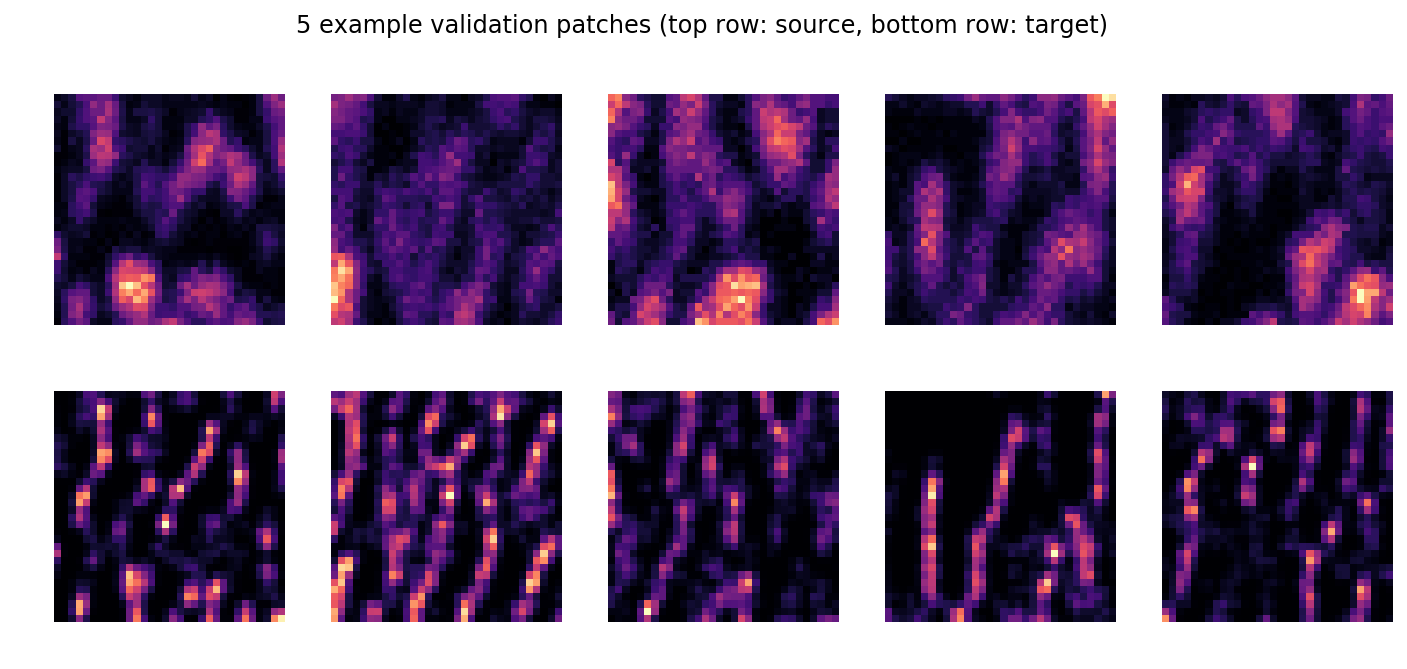

In [16]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [17]:
config = Config(axes, n_channel_in, n_channel_out, unet_n_depth=3, train_batch_size=8, train_steps_per_epoch=20)
print(config)
vars(config)

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=8, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=20, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 20,
 'train_learning_rate': 0.0004,
 'train_batch_size': 8,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [18]:
model = ProjectionCARE(config, 'my_model', basedir='models')

C:\ProgramData\Anaconda3\lib\site-packages\csbdeep\models\care_standard.py:139: UserWarning: output path for model already exists, files may be overwritten: C:\Users\Administrator\Documents\REVORGDATA\paper\extractionScripts\deeplearn_analysis\projection\models\my_model
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model.proj_params

ProjectionParameters(axis='Z', n_depth=4, n_filt=8, n_conv_per_depth=1, kern=(3, 3, 3), pool=(1, 2, 2))

In [20]:
import tensorflow as tf

hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [21]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
20/20 [==============================] - ETA: 55s - loss: 0.1190 - mse: 0.0397 - mae: 0.11 - ETA: 44s - loss: 0.1087 - mse: 0.0349 - mae: 0.10 - ETA: 39s - loss: 0.1135 - mse: 0.0364 - mae: 0.11 - ETA: 35s - loss: 0.1141 - mse: 0.0373 - mae: 0.11 - ETA: 32s - loss: 0.1103 - mse: 0.0351 - mae: 0.11 - ETA: 30s - loss: 0.1090 - mse: 0.0342 - mae: 0.10 - ETA: 27s - loss: 0.1070 - mse: 0.0331 - mae: 0.10 - ETA: 24s - loss: 0.1050 - mse: 0.0326 - mae: 0.10 - ETA: 22s - loss: 0.1052 - mse: 0.0324 - mae: 0.10 - ETA: 20s - loss: 0.1053 - mse: 0.0321 - mae: 0.10 - ETA: 18s - loss: 0.1044 - mse: 0.0318 - mae: 0.10 - ETA: 16s - loss: 0.1045 - mse: 0.0314 - mae

20/20 [==============================] - ETA: 37s - loss: 0.0544 - mse: 0.0083 - mae: 0.05 - ETA: 35s - loss: 0.0536 - mse: 0.0078 - mae: 0.05 - ETA: 33s - loss: 0.0532 - mse: 0.0077 - mae: 0.05 - ETA: 31s - loss: 0.0529 - mse: 0.0076 - mae: 0.05 - ETA: 29s - loss: 0.0549 - mse: 0.0081 - mae: 0.05 - ETA: 28s - loss: 0.0550 - mse: 0.0081 - mae: 0.05 - ETA: 26s - loss: 0.0545 - mse: 0.0080 - mae: 0.05 - ETA: 24s - loss: 0.0553 - mse: 0.0082 - mae: 0.05 - ETA: 22s - loss: 0.0551 - mse: 0.0082 - mae: 0.05 - ETA: 20s - loss: 0.0552 - mse: 0.0082 - mae: 0.05 - ETA: 18s - loss: 0.0554 - mse: 0.0082 - mae: 0.05 - ETA: 15s - loss: 0.0555 - mse: 0.0083 - mae: 0.05 - ETA: 13s - loss: 0.0557 - mse: 0.0084 - mae: 0.05 - ETA: 11s - loss: 0.0556 - mse: 0.0083 - mae: 0.05 - ETA: 9s - loss: 0.0556 - mse: 0.0084 - mae: 0.0556 - ETA: 7s - loss: 0.0556 - mse: 0.0084 - mae: 0.055 - ETA: 5s - loss: 0.0554 - mse: 0.0084 - mae: 0.055 - ETA: 3s - loss: 0.0553 - mse: 0.0083 - mae: 0.055 - ETA: 1s - loss: 0.0551

20/20 [==============================] - ETA: 37s - loss: 0.0477 - mse: 0.0057 - mae: 0.04 - ETA: 36s - loss: 0.0440 - mse: 0.0050 - mae: 0.04 - ETA: 33s - loss: 0.0440 - mse: 0.0052 - mae: 0.04 - ETA: 31s - loss: 0.0445 - mse: 0.0054 - mae: 0.04 - ETA: 29s - loss: 0.0450 - mse: 0.0055 - mae: 0.04 - ETA: 27s - loss: 0.0445 - mse: 0.0055 - mae: 0.04 - ETA: 25s - loss: 0.0445 - mse: 0.0054 - mae: 0.04 - ETA: 23s - loss: 0.0450 - mse: 0.0055 - mae: 0.04 - ETA: 21s - loss: 0.0451 - mse: 0.0057 - mae: 0.04 - ETA: 19s - loss: 0.0450 - mse: 0.0056 - mae: 0.04 - ETA: 17s - loss: 0.0447 - mse: 0.0055 - mae: 0.04 - ETA: 15s - loss: 0.0454 - mse: 0.0056 - mae: 0.04 - ETA: 13s - loss: 0.0450 - mse: 0.0056 - mae: 0.04 - ETA: 11s - loss: 0.0460 - mse: 0.0058 - mae: 0.04 - ETA: 9s - loss: 0.0460 - mse: 0.0058 - mae: 0.0460 - ETA: 7s - loss: 0.0459 - mse: 0.0058 - mae: 0.045 - ETA: 5s - loss: 0.0456 - mse: 0.0058 - mae: 0.045 - ETA: 3s - loss: 0.0459 - mse: 0.0058 - mae: 0.045 - ETA: 1s - loss: 0.0455

20/20 [==============================] - ETA: 36s - loss: 0.0336 - mse: 0.0031 - mae: 0.03 - ETA: 35s - loss: 0.0357 - mse: 0.0034 - mae: 0.03 - ETA: 33s - loss: 0.0362 - mse: 0.0036 - mae: 0.03 - ETA: 31s - loss: 0.0363 - mse: 0.0036 - mae: 0.03 - ETA: 29s - loss: 0.0364 - mse: 0.0036 - mae: 0.03 - ETA: 27s - loss: 0.0371 - mse: 0.0037 - mae: 0.03 - ETA: 25s - loss: 0.0369 - mse: 0.0037 - mae: 0.03 - ETA: 23s - loss: 0.0364 - mse: 0.0036 - mae: 0.03 - ETA: 21s - loss: 0.0362 - mse: 0.0036 - mae: 0.03 - ETA: 19s - loss: 0.0365 - mse: 0.0036 - mae: 0.03 - ETA: 17s - loss: 0.0364 - mse: 0.0036 - mae: 0.03 - ETA: 15s - loss: 0.0361 - mse: 0.0036 - mae: 0.03 - ETA: 13s - loss: 0.0360 - mse: 0.0035 - mae: 0.03 - ETA: 11s - loss: 0.0360 - mse: 0.0035 - mae: 0.03 - ETA: 9s - loss: 0.0356 - mse: 0.0035 - mae: 0.0356 - ETA: 7s - loss: 0.0354 - mse: 0.0034 - mae: 0.035 - ETA: 5s - loss: 0.0353 - mse: 0.0034 - mae: 0.035 - ETA: 3s - loss: 0.0352 - mse: 0.0034 - mae: 0.035 - ETA: 1s - loss: 0.0353

20/20 [==============================] - ETA: 37s - loss: 0.0300 - mse: 0.0027 - mae: 0.03 - ETA: 35s - loss: 0.0298 - mse: 0.0025 - mae: 0.02 - ETA: 33s - loss: 0.0291 - mse: 0.0024 - mae: 0.02 - ETA: 31s - loss: 0.0280 - mse: 0.0022 - mae: 0.02 - ETA: 28s - loss: 0.0282 - mse: 0.0023 - mae: 0.02 - ETA: 26s - loss: 0.0278 - mse: 0.0022 - mae: 0.02 - ETA: 24s - loss: 0.0282 - mse: 0.0023 - mae: 0.02 - ETA: 22s - loss: 0.0283 - mse: 0.0023 - mae: 0.02 - ETA: 20s - loss: 0.0280 - mse: 0.0022 - mae: 0.02 - ETA: 19s - loss: 0.0280 - mse: 0.0022 - mae: 0.02 - ETA: 17s - loss: 0.0282 - mse: 0.0022 - mae: 0.02 - ETA: 15s - loss: 0.0279 - mse: 0.0022 - mae: 0.02 - ETA: 13s - loss: 0.0280 - mse: 0.0022 - mae: 0.02 - ETA: 11s - loss: 0.0277 - mse: 0.0022 - mae: 0.02 - ETA: 9s - loss: 0.0275 - mse: 0.0022 - mae: 0.0275 - ETA: 7s - loss: 0.0275 - mse: 0.0022 - mae: 0.027 - ETA: 5s - loss: 0.0274 - mse: 0.0021 - mae: 0.027 - ETA: 3s - loss: 0.0273 - mse: 0.0021 - mae: 0.027 - ETA: 1s - loss: 0.0274

20/20 [==============================] - ETA: 36s - loss: 0.0249 - mse: 0.0018 - mae: 0.02 - ETA: 34s - loss: 0.0236 - mse: 0.0017 - mae: 0.02 - ETA: 33s - loss: 0.0237 - mse: 0.0017 - mae: 0.02 - ETA: 31s - loss: 0.0242 - mse: 0.0018 - mae: 0.02 - ETA: 29s - loss: 0.0243 - mse: 0.0018 - mae: 0.02 - ETA: 27s - loss: 0.0243 - mse: 0.0018 - mae: 0.02 - ETA: 25s - loss: 0.0248 - mse: 0.0018 - mae: 0.02 - ETA: 23s - loss: 0.0249 - mse: 0.0019 - mae: 0.02 - ETA: 21s - loss: 0.0252 - mse: 0.0019 - mae: 0.02 - ETA: 19s - loss: 0.0251 - mse: 0.0019 - mae: 0.02 - ETA: 17s - loss: 0.0253 - mse: 0.0019 - mae: 0.02 - ETA: 15s - loss: 0.0254 - mse: 0.0019 - mae: 0.02 - ETA: 13s - loss: 0.0253 - mse: 0.0019 - mae: 0.02 - ETA: 11s - loss: 0.0250 - mse: 0.0019 - mae: 0.02 - ETA: 9s - loss: 0.0248 - mse: 0.0018 - mae: 0.0248 - ETA: 7s - loss: 0.0249 - mse: 0.0019 - mae: 0.024 - ETA: 5s - loss: 0.0249 - mse: 0.0019 - mae: 0.024 - ETA: 3s - loss: 0.0247 - mse: 0.0018 - mae: 0.024 - ETA: 1s - loss: 0.0247

20/20 [==============================] - ETA: 37s - loss: 0.0225 - mse: 0.0016 - mae: 0.02 - ETA: 34s - loss: 0.0228 - mse: 0.0016 - mae: 0.02 - ETA: 33s - loss: 0.0220 - mse: 0.0016 - mae: 0.02 - ETA: 31s - loss: 0.0226 - mse: 0.0016 - mae: 0.02 - ETA: 27s - loss: 0.0230 - mse: 0.0017 - mae: 0.02 - ETA: 26s - loss: 0.0234 - mse: 0.0017 - mae: 0.02 - ETA: 24s - loss: 0.0233 - mse: 0.0017 - mae: 0.02 - ETA: 22s - loss: 0.0234 - mse: 0.0017 - mae: 0.02 - ETA: 20s - loss: 0.0234 - mse: 0.0017 - mae: 0.02 - ETA: 19s - loss: 0.0233 - mse: 0.0017 - mae: 0.02 - ETA: 17s - loss: 0.0232 - mse: 0.0017 - mae: 0.02 - ETA: 15s - loss: 0.0229 - mse: 0.0016 - mae: 0.02 - ETA: 13s - loss: 0.0230 - mse: 0.0017 - mae: 0.02 - ETA: 11s - loss: 0.0230 - mse: 0.0016 - mae: 0.02 - ETA: 9s - loss: 0.0233 - mse: 0.0017 - mae: 0.0233 - ETA: 7s - loss: 0.0232 - mse: 0.0017 - mae: 0.023 - ETA: 5s - loss: 0.0234 - mse: 0.0017 - mae: 0.023 - ETA: 3s - loss: 0.0235 - mse: 0.0017 - mae: 0.023 - ETA: 1s - loss: 0.0234

20/20 [==============================] - ETA: 36s - loss: 0.0252 - mse: 0.0018 - mae: 0.02 - ETA: 34s - loss: 0.0242 - mse: 0.0018 - mae: 0.02 - ETA: 32s - loss: 0.0246 - mse: 0.0018 - mae: 0.02 - ETA: 31s - loss: 0.0246 - mse: 0.0018 - mae: 0.02 - ETA: 29s - loss: 0.0250 - mse: 0.0018 - mae: 0.02 - ETA: 27s - loss: 0.0252 - mse: 0.0019 - mae: 0.02 - ETA: 25s - loss: 0.0249 - mse: 0.0018 - mae: 0.02 - ETA: 23s - loss: 0.0250 - mse: 0.0018 - mae: 0.02 - ETA: 21s - loss: 0.0246 - mse: 0.0018 - mae: 0.02 - ETA: 19s - loss: 0.0246 - mse: 0.0018 - mae: 0.02 - ETA: 17s - loss: 0.0241 - mse: 0.0018 - mae: 0.02 - ETA: 15s - loss: 0.0239 - mse: 0.0017 - mae: 0.02 - ETA: 13s - loss: 0.0239 - mse: 0.0017 - mae: 0.02 - ETA: 11s - loss: 0.0237 - mse: 0.0017 - mae: 0.02 - ETA: 9s - loss: 0.0238 - mse: 0.0017 - mae: 0.0238 - ETA: 7s - loss: 0.0238 - mse: 0.0017 - mae: 0.023 - ETA: 5s - loss: 0.0238 - mse: 0.0017 - mae: 0.023 - ETA: 3s - loss: 0.0237 - mse: 0.0017 - mae: 0.023 - ETA: 1s - loss: 0.0236

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


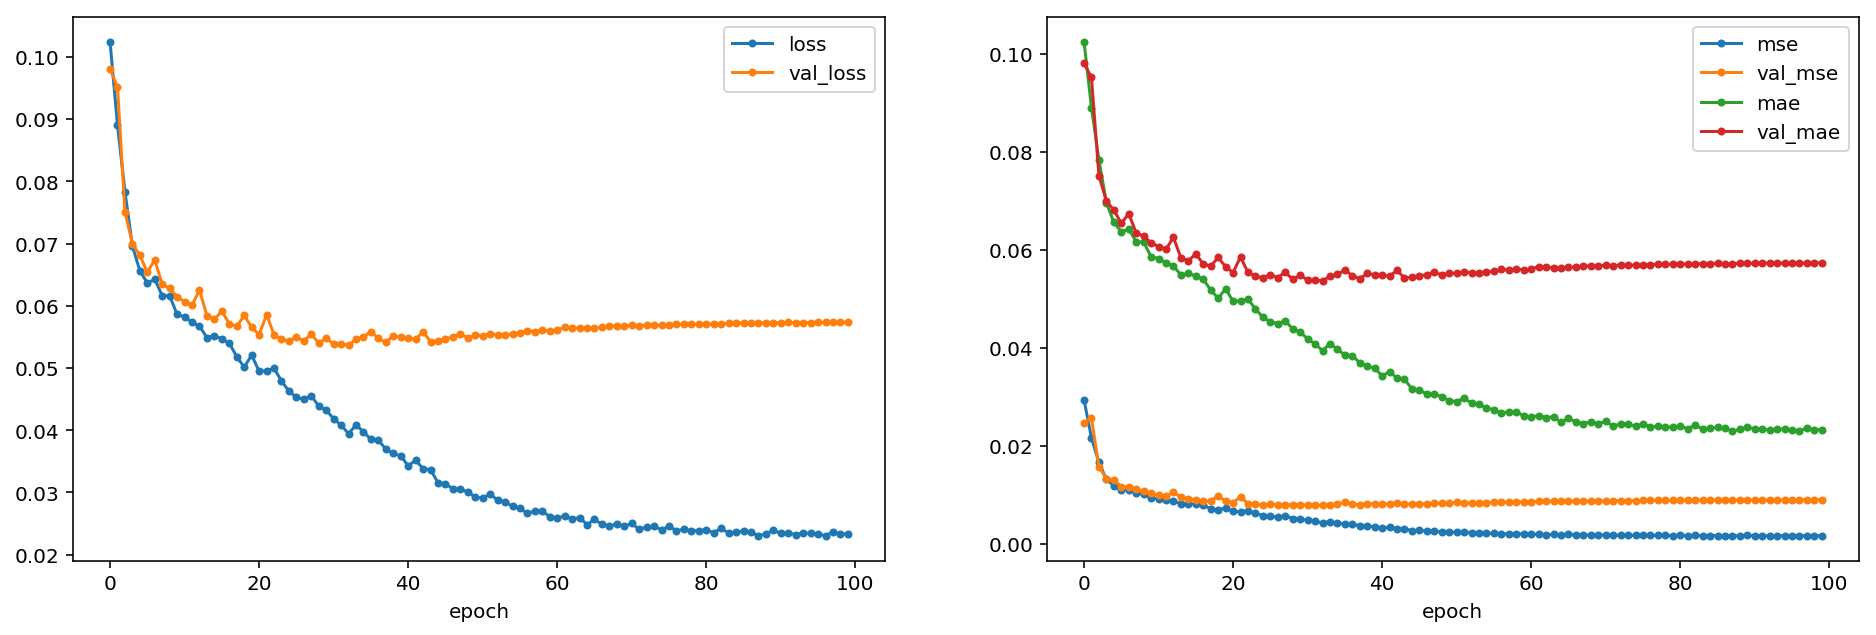

In [22]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

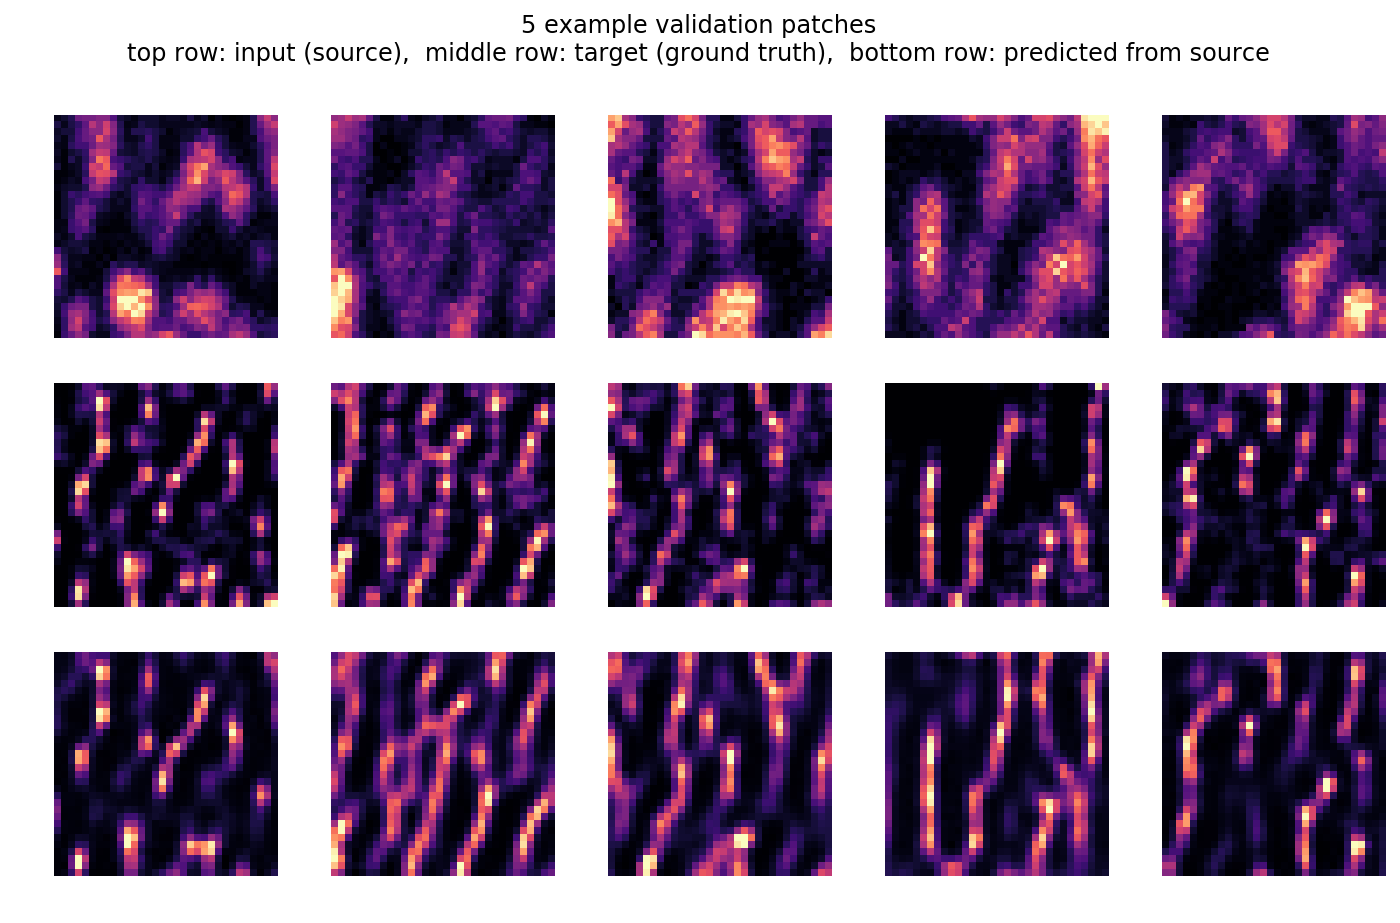

In [23]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

In [24]:
model.export_TF()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpznrx34o9\model\saved_model.pb

Model exported in TensorFlow's SavedModel format:
C:\Users\Administrator\Documents\REVORGDATA\paper\extractionScripts\deeplearn_analysis\projection\models\my_model\TF_SavedModel.zip


<hr style="height:2px;">

# STEP 3: PREDICTION AND SAVE FINAL RECONSTRUCTION

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR images and the semantics of each axis (e.g. which one is considered a color channel, etc.).



In [25]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import ProjectionCARE

input  image size = (31, 512, 512)
output image size = (512, 512)
source image size = (31, 512, 512)
source image axes = ZYX
target image size = (512, 512)


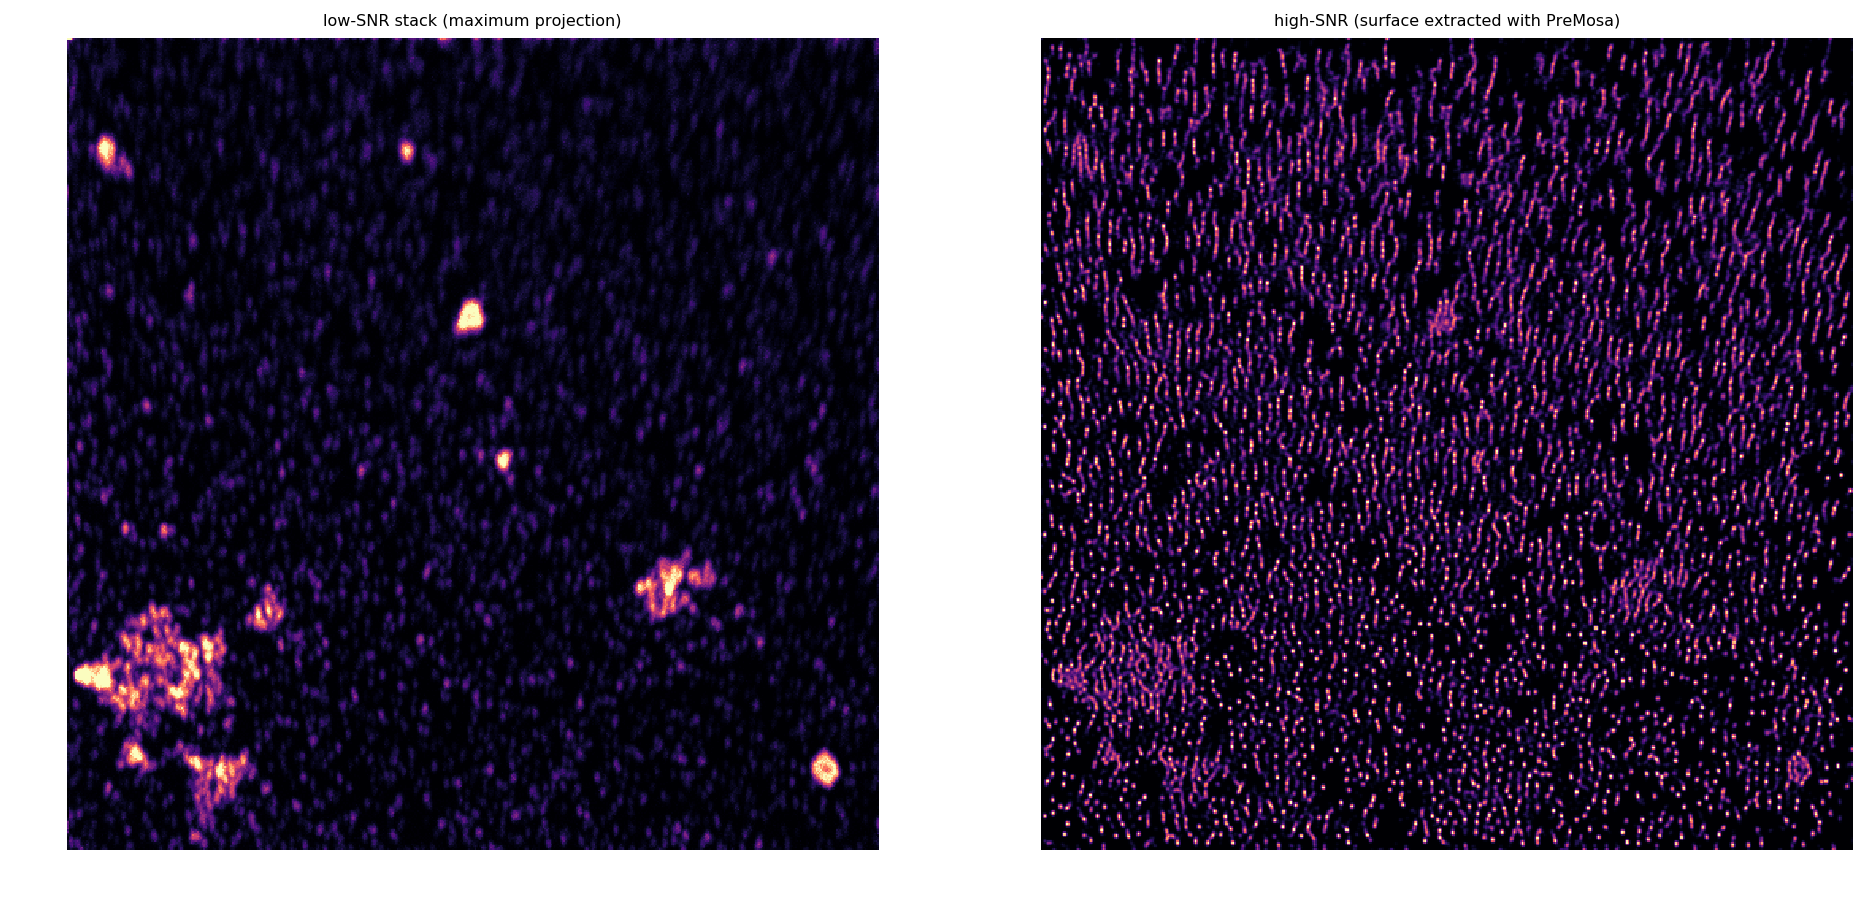

In [27]:
#y = imread('data/retinasrb/s5-c05long-26slices-fluo.tiff')
#x = imread('data/retinab/s5-c05long-26slices-fluo.tif')

y = imread('data/retinasrbb/s5-c05long-31slices-si.tif')
x = imread('data/retinabb/s5-c05long-31slices-si.tif')
print('input  image size =', x.shape)
print('output image size =', y.shape)

axes = 'ZYX'
print('source image size =', x.shape)
print('source image axes =', axes)
print('target image size =', y.shape)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,np.broadcast_to(y,x.shape)]),
          title_list=[['low-SNR stack (maximum projection)','high-SNR (surface extracted with PreMosa)']], 
          pmin=2,pmax=99.8);

In [28]:
model = ProjectionCARE(config=None, name='my_model', basedir='models')

Loading network weights from 'weights_best.h5'.


In [29]:
%%time
restored = model.predict(x, axes)

Wall time: 20.9 s


In [30]:
Path('results').mkdir(exist_ok=True)
axes_restored = axes.replace(model.proj_params.axis,'')
save_tiff_imagej_compatible('results/%s_sriondeep_nanotagsibyfluotrainF.tif' % model.name, restored, axes_restored)

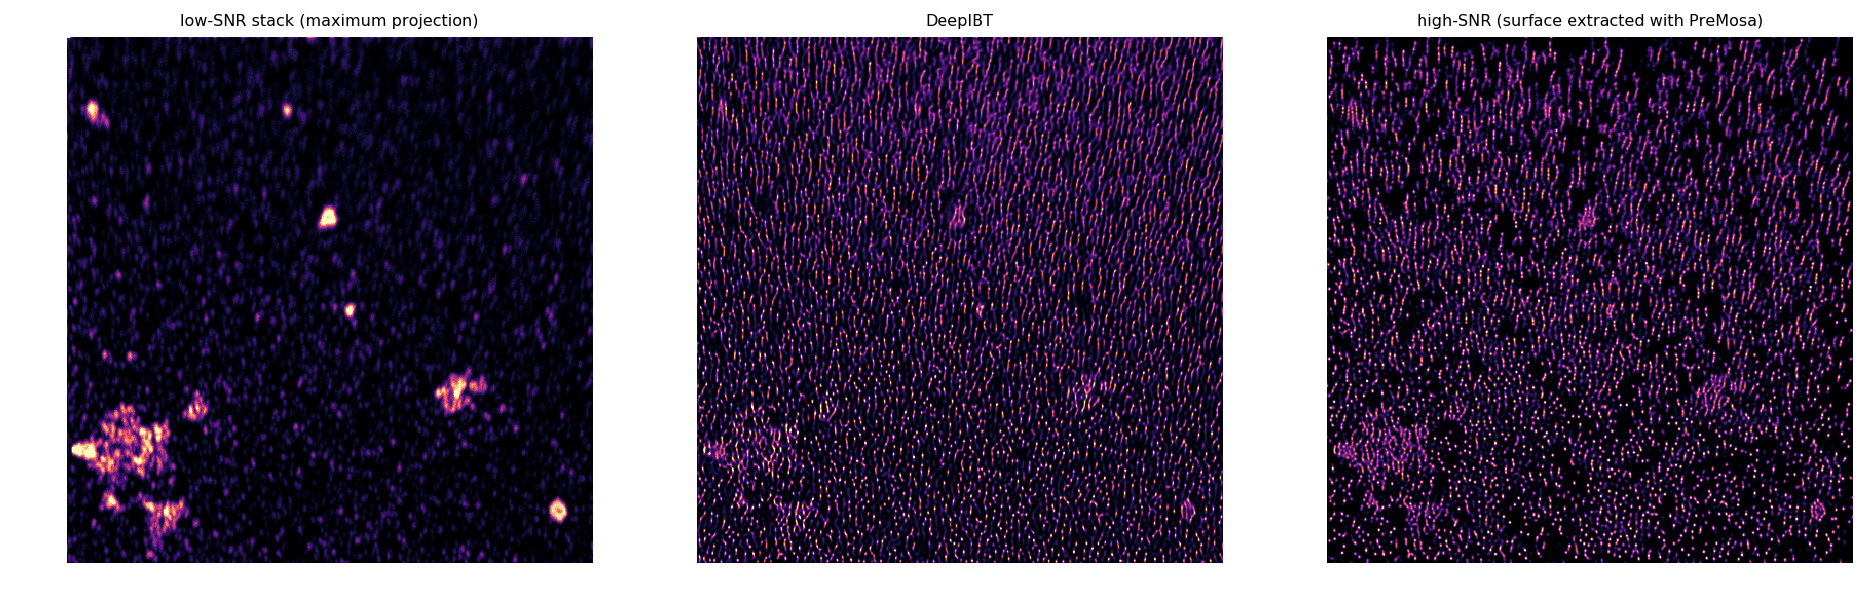

In [31]:
plt.figure(figsize=(16,10))
plot_some(np.stack([x,np.broadcast_to(restored,x.shape),np.broadcast_to(y,x.shape)]),
          title_list=[['low-SNR stack (maximum projection)','DeepIBT','high-SNR (surface extracted with PreMosa)']], 
          pmin=2,pmax=99.8);

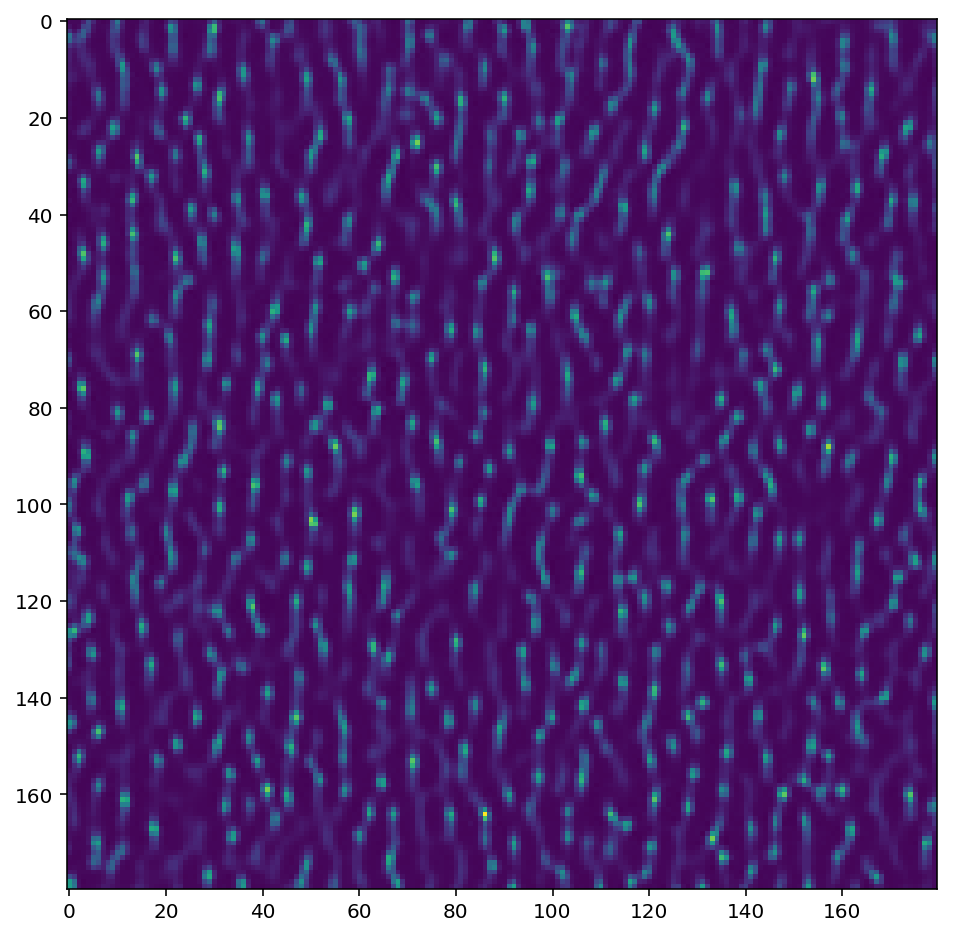

In [32]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as pyplot

im = Image.open('results/my_model_sriondeep_nanotagsibyfluotrainF.tif')


im = im.crop((160,305,340,485))
image=im
im = 255*(image - np.min(image))/np.ptp(image).astype(int)


#im = im.crop((195,310,375,490))
#im.save('sriondeep_nanotagfluobysitrainFsmall.tif')
matplotlib.image.imsave('sriondeep_nanotagsibyfluotrainFsmallgray.tif', im)


img = im
fig=pyplot.figure(figsize = (8, 8))

pyplot.imshow(img)


pyplot.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


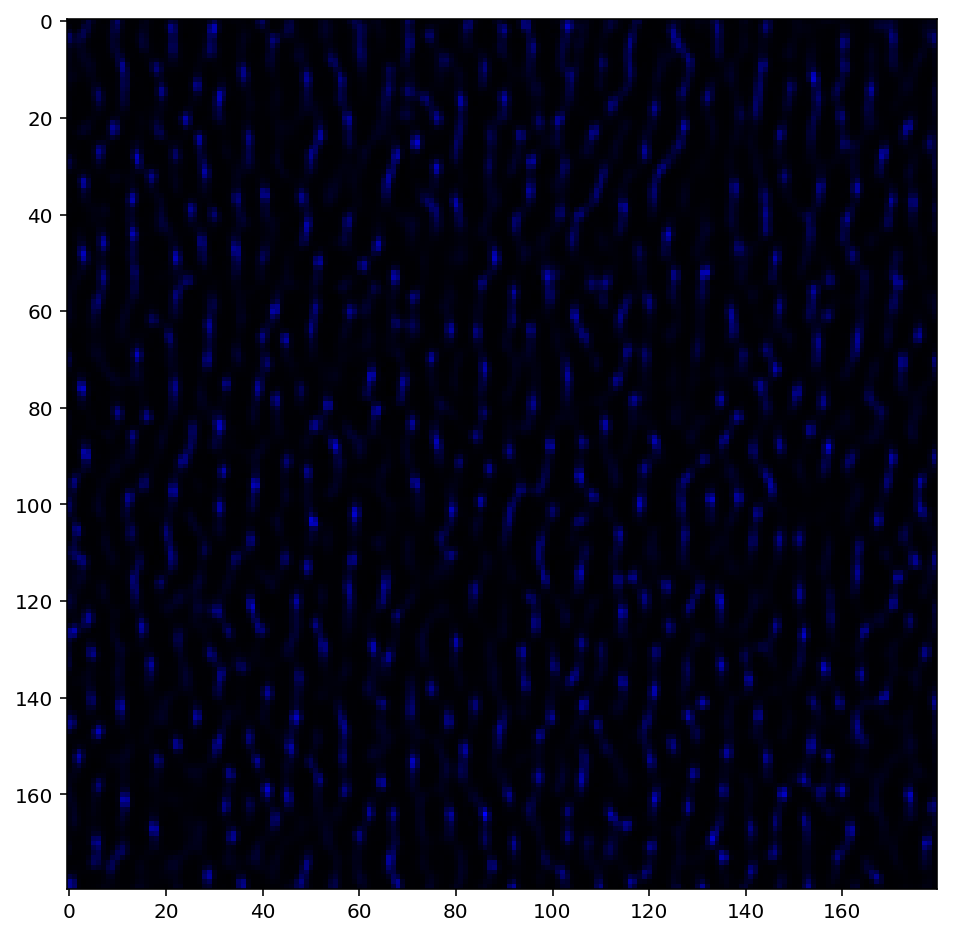

(180, 180, 3)


In [33]:
from PIL import Image
import numpy as np

color=(0, 255, 0)
im = np.array(img)
#r, g, b, a = np.rollaxis(x, axis=-1)
#r[a == 0] = color[0]

#im=r


dim = np.zeros((180,180))

#select blue color for the image display and save
R = np.stack((dim,dim, im), axis=2)/255;

fig=pyplot.figure(figsize = (8, 8))
pyplot.imshow(R)
pyplot.show()
print(R.shape)



import matplotlib

matplotlib.image.imsave('sriondeep_nanotagsibyfluotrainFsmallcolor.tif', R)



rgb = np.zeros((255, 255, 3), dtype=np.uint8)
rgb[..., 0] = np.arange(255)
rgb[..., 1] = 55
rgb[..., 2] =  1- np.arange(255)